In [1]:
pip install transformers


In [2]:
!pip install chart_studio

In [3]:
pip install fastai

In [4]:
pip install scikit-learn

In [5]:
%tensorflow_version 2.x

In [6]:
# Restart runtime using 'Runtime' -> 'Restart runtime...'
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

TensorFlow 1.x selected.
1.15.2
Instructions for updating:
non-resource variables are not supported in the long term


In [7]:
import pandas as pd
import io
import os
import json
from fastai.text import *
from fastai.metrics import *
from transformers import RobertaTokenizer

In [8]:
# Creating a config object to store task specific information
class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)
        
config = Config(
    testing=False,
    seed = 2020,
    roberta_model_name='roberta-base', # can also be exchnaged with roberta-base 
    max_lr=1e-5,
    epochs=10,
    use_fp16=False,
    bs=4, 
    max_seq_len=256, 
    num_labels = 3,
    hidden_dropout_prob=.05,
    hidden_size=768, # 1024 for roberta-large
    start_tok = "<s>",
    end_tok = "</s>",
)

In [9]:
_## Mount Drive into Colab
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/DS4A_PROJECT/eval_1")
os.listdir()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['Classification_with_RoBERTa.ipynb']

In [10]:
from google.colab import files
uploaded = files.upload()

Saving roberta_eval_1_v2.csv to roberta_eval_1_v2.csv
Saving training_data.csv to training_data.csv


In [11]:
df = pd.read_csv(io.StringIO(uploaded['training_data.csv'].decode('cp1252'))) 
df.head()

,Unnamed: 0,reply_split,classification
0,0,Could you let me know if the Gambler folks pro...,irrelevant
1,1,Plenty of lighter Chinese sheets.,irrelevant
2,2,That would be great,irrelevant
3,3,Sorry this won't be a direct answer.But in you...,comparative
4,4,[/quote]ok rejected idea of getting Sigmaso no...,irrelevant


In [12]:
df = df[["reply_split", "classification"]]
df.columns

Index(['reply_split', 'classification'], dtype='object')

In [13]:
test_df = pd.read_csv(io.StringIO(uploaded['roberta_eval_1_v2.csv'].decode('cp1252')))
test_df.head(3)

,id,thread_title,reply_split
0,5f686bc7b59794ca78c70902,Tenergy 05FX vs Tenergy 64FX,"Hi stao, the response of the T64fx changes dep..."
1,5f686bc7b59794ca78c70902,Tenergy 05FX vs Tenergy 64FX,Usually I have a Primorac Carbon and I'm offen...
2,5f686bc7b59794ca78c70902,Tenergy 05FX vs Tenergy 64FX,I used T05fx before and I really appreciate th...


In [14]:
df.isna().sum()

reply_split       0
classification    0
dtype: int64

In [15]:
test_df.isna().sum()

id               0
thread_title     0
reply_split     29
dtype: int64

In [16]:
test_df = test_df.dropna()
print(test_df.isna().sum())

id              0
thread_title    0
reply_split     0
dtype: int64


In [17]:
print(df.shape,test_df.shape)

(2726, 2) (20488, 3)


In [18]:
df.classification.unique()

array(['irrelevant', 'comparative', 'descriptive'], dtype=object)

In [19]:
if config.testing: df = df[:5000]

In [20]:
feat_cols = "reply_split"
label_cols = "classification"
feat_cols1 = "reply_split"


In [21]:
class FastAiRobertaTokenizer(BaseTokenizer):
    """Wrapper around RobertaTokenizer to be compatible with fastai"""
    def __init__(self, tokenizer: RobertaTokenizer, max_seq_len: int=128, **kwargs): 
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len 
    def __call__(self, *args, **kwargs): 
        return self 
    def tokenizer(self, t:str) -> List[str]: 
        """Adds Roberta bos and eos tokens and limits the maximum sequence length""" 
        return [config.start_tok] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + [config.end_tok]

In [22]:
# create fastai tokenizer for roberta
roberta_tok = RobertaTokenizer.from_pretrained("roberta-base")

fastai_tokenizer = Tokenizer(tok_func=FastAiRobertaTokenizer(roberta_tok, max_seq_len=config.max_seq_len), 
                             pre_rules=[], post_rules=[])

In [23]:
roberta_tok

In [24]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [25]:
path = F"/content/gdrive/My Drive/DS4A_PROJECT/eval_1" 
roberta_tok.save_vocabulary(path)

('/content/gdrive/My Drive/DS4A_PROJECT/eval_1/vocab.json',
 '/content/gdrive/My Drive/DS4A_PROJECT/eval_1/merges.txt')

In [26]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/DS4A_PROJECT/eval_1")
os.listdir()

Mounted at /content/drive


['Classification_with_RoBERTa.ipynb',
 'roberta_eval_1_v2.csv',
 'training_data.csv',
 'vocab.json',
 'merges.txt']

In [27]:
# create fastai vocabulary for roberta
path = Path()
roberta_tok.save_vocabulary(path)

with open('vocab.json', 'r') as f:
    roberta_vocab_dict = json.load(f)
    
fastai_roberta_vocab = Vocab(list(roberta_vocab_dict.keys()))

In [28]:
# Setting up pre-processors
class RobertaTokenizeProcessor(TokenizeProcessor):
    def __init__(self, tokenizer):
         super().__init__(tokenizer=tokenizer, include_bos=False, include_eos=False)

class RobertaNumericalizeProcessor(NumericalizeProcessor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)


def get_roberta_processor(tokenizer:Tokenizer=None, vocab:Vocab=None):
    """
    Constructing preprocessors for Roberta
    We remove sos and eos tokens since we add that ourselves in the tokenizer.
    We also use a custom vocabulary to match the numericalization with the original Roberta model.
    """
    return [RobertaTokenizeProcessor(tokenizer=tokenizer), RobertaNumericalizeProcessor(vocab=vocab)]

In [29]:
# Creating a Roberta specific DataBunch class
class RobertaDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training Roberta"
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds, path:PathOrStr='.', bs:int=64, val_bs:int=None, pad_idx=1,
               pad_first=True, device:torch.device=None, no_check:bool=False, backwards:bool=False, 
               dl_tfms:Optional[Collection[Callable]]=None, **dl_kwargs) -> DataBunch:
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(pad_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, dl_tfms=dl_tfms, collate_fn=collate_fn, no_check=no_check)


In [30]:
class RobertaTextList(TextList):
    _bunch = RobertaDataBunch
    _label_cls = TextList

In [31]:
import concurrent.futures

# loading the tokenizer and vocab processors
processor = get_roberta_processor(tokenizer=fastai_tokenizer, vocab=fastai_roberta_vocab)
processor

In [32]:
# creating our databunch 
data = RobertaTextList.from_df(df, ".", cols=feat_cols, processor=processor) \
    .split_by_rand_pct(seed=config.seed) \
    .label_from_df(cols=label_cols,label_cls=CategoryList) \
    .add_test(RobertaTextList.from_df(test_df, ".", cols=feat_cols1, processor=processor)) \
    .databunch(bs=config.bs, pad_first=False, pad_idx=0)


In [33]:
data

RobertaDataBunch;

Train: LabelList (2181 items)
x: RobertaTextList
<s> Could Ġyou Ġlet Ġme Ġknow Ġif Ġthe ĠGamb ler Ġfolks Ġprovided Ġan Ġapproximate Ġhardness Ġfor Ġthe Ġdifferent Ġsp ong es Ġand , Ġif Ġso , Ġwhich Ġhardness Ġscale Ġit Ġis Ġbased Ġon ? </s>,<s> Pl enty Ġof Ġlighter ĠChinese Ġsheets . </s>,<s> That Ġwould Ġbe Ġgreat </s>,<s> Sorry Ġthis Ġwon 't Ġbe Ġa Ġdirect Ġanswer . But Ġin Ġyour Ġsituation , ĠI Ġwould Ġbuy ĠH 3 ĠProvincial , Ġwhich Ġis Ġa Ġvery Ġpredictable Ġrubber Ġin Ġmy Ġexperience . </s>,<s> [/ quote ] ok Ġrejected Ġidea Ġof Ġgetting ĠSig mas o Ġnow Ġleft : V ega ĠPro O mega ĠPro i Ġwondering Ġif ĠVega ĠPro Ġhas Ġgood Ġspeed Ġon Ġdefensive Ġblade Ġlike ĠDon ic ĠDef play ĠSen so Ġ( 1 Ġplayer Ġsaid Ġit Ġwill Ġbe Ġtoo Ġslow ) about ĠOmega ĠPro .. Ġwhat Ġversion ĠIV Ġor ĠV ? </s>
y: CategoryList
irrelevant,irrelevant,irrelevant,comparative,irrelevant
Path: .;

Valid: LabelList (545 items)
x: RobertaTextList
<s> The Ġonly Ġissues Ġthat ĠI Ġhave Ġwith Ġthe ĠZero Ġar

In [34]:
# Building the Model

In [35]:
import torch.nn as nn
from transformers import RobertaModel

# defining our model architecture 
class CustomRobertaModel(nn.Module):
    def __init__(self,num_labels=3):
        super(CustomRobertaModel,self).__init__()
        self.num_labels = num_labels
        self.roberta = RobertaModel.from_pretrained(config.roberta_model_name)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, num_labels) # defining final output layer
        
    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        _ , pooled_output = self.roberta(input_ids, token_type_ids, attention_mask) # 
        logits = self.classifier(pooled_output)        
        return logits

In [36]:
roberta_model = CustomRobertaModel(num_labels=config.num_labels)

learn = Learner(data, roberta_model, metrics=[accuracy])

In [37]:
learn.model.roberta.train() # setting roberta to train as it is in eval mode by default
learn.fit_one_cycle(config.epochs, max_lr=config.max_lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.744036,0.739212,0.732110,00:32
1,0.517996,0.504892,0.800000,00:32
2,0.385848,0.464601,0.833028,00:33
3,0.304987,0.476454,0.825688,00:32
4,0.264465,0.525810,0.807339,00:32
5,0.105791,0.695563,0.816514,00:32
6,0.075849,0.753332,0.820184,00:32
7,0.043601,0.817229,0.825688,00:33
8,0.037807,0.870499,0.818349,00:32
9,0.027016,0.870555,0.814679,00:32


In [76]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    learn.model.roberta.eval()
    preds = learn.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in data.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    ordered_preds = preds[reverse_sampler, :]
    pred_values = np.argmax(ordered_preds, axis=1)
    return ordered_preds, pred_values

In [77]:
preds, pred_values = get_preds_as_nparray(DatasetType.Valid)

In [78]:
# accuracy on valid
(pred_values == data.valid_ds.y.items).mean()

0.8146788990825689

In [79]:
print(learn.model)

CustomRobertaModel(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNor

In [80]:
learn.model.roberta.eval()

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0): RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropout): Drop

In [81]:
learn.show_results()

text,target,prediction
<s> My Ġgame Ġhas Ġimproved Ġnoticeably . They Ġare Ġa Ġtiny Ġbit Ġheavier Ġthan Ġthe ĠSn ipe ĠIII Ġbut ĠI Ġgot Ġused Ġto Ġthe Ġweight Ġdifference Ġvery Ġquickly . They Ġplay Ġsimilar Ġto Ġthe ĠSn ipe Ġbut Ġoffer Ġa Ġlittle Ġmore Ġcontrol Ġ/ Ġplacement Ġand Ġa Ġlot Ġmore Ġspin . The Ġthrow Ġis Ġalso Ġslightly Ġhigher Ġthan Ġthe ĠSn ipe Ġand Ġthe Ġarc Ġis Ġgreater Ġtoo . In Ġfact ĠI,irrelevant,comparative
<s> Personally ĠI Ġwould Ġcompromise Ġthe Ġstiffness Ġfor Ġmore Ġflexibility Ġallowing Ġyou Ġto Ġuse Ġmedium Ġto Ġlow Ġthrow Ġrub bers Ġso Ġthat Ġyou Ġcan Ġget Ġyour Ġtechnique Ġright Ġand Ġlearn Ġto Ġplay Ġmore Ġeasily Ġwith Ġloop ing Ġetc . So Ġmaybe Ġanother Ġthread Ġmight Ġbe Ġneeded Ġto Ġsee Ġif Ġyou Ġcould Ġuse Ġa Ġless Ġstiff Ġj pen Ġblade Ġ? Normally Ġwith Ġa Ġrubber Ġthe Ġarc Ġstarts Ġto Ġflatt en Ġout,irrelevant,irrelevant
"<s> For Ġme , ĠI Ġcould Ġplay Ġboth Ġoffensive Ġand Ġdefensive Ġeasier Ġand Ġbetter Ġwith Ġit Ġthan Ġusing ĠT 05 Ġ( for Ġme Ġeasier Ġto Ġuse Ġoffensively Ġthan Ġdefensively ). If Ġyou Ġare Ġhigher Ġlevel Ġand / or Ġwant Ġto Ġput Ġin Ġthe Ġhours Ġthen Ġyou Ġcould Ġany Ġoffensive Ġrub bers Ġand Ġuse Ġit Ġdefensively Ġtoo Ġlike ĠJ oo , Ġetc . My Ġrecommendation Ġin Ġpart Ġbecause Ġit Ġworks Ġgood",irrelevant,irrelevant
<s> Gen ius ĠSound Ġis Ġsupposedly Ġa Ġvery Ġgood Ġrubber Ġbut Ġa Ġmore Ġup Ġto Ġdate Ġversion Ġof Ġit Ġwould Ġthe Ġ5 Q Ġsound Ġat Ġthe Ġsame Ġ37 . 5 Ġdegree . H aven 't Ġtried Ġthe Ġ5 Q Ġsound Ġbut Ġthe Ġ5 Q Ġis Ġa Ġsuper Ġrubber Ġbut Ġimagine Ġit Ġwould Ġbe Ġtoo Ġadvanced Ġfor Ġyou Ġat Ġthis Ġstage Ġbut Ġit Ġcan Ġwork Ġwell Ġfor ĠShake hand ers Ġon,descriptive,irrelevant


In [82]:
preds, target = learn.get_preds()

In [83]:
preds

tensor([[9.5192e-01, 4.5022e-02, 3.0555e-03],
        [2.9606e-04, 1.9495e-03, 9.9775e-01],
        [7.7213e-03, 2.2837e-03, 9.9000e-01],
        ...,
        [3.8356e-04, 3.1864e-04, 9.9930e-01],
        [3.1901e-04, 2.9088e-04, 9.9939e-01],
        [5.0556e-04, 3.4502e-04, 9.9915e-01]])

In [84]:
target

tensor([2, 2, 2, 1, 0, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 1, 2, 1, 0, 0, 2, 2,
        1, 2, 1, 2, 2, 0, 2, 2, 0, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0, 2,
        2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 1, 2, 1, 2, 1, 2, 0, 2, 2, 1, 2, 2, 1,
        0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0,
        2, 0, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 2, 2, 0, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2, 2, 2,
        1, 2, 2, 0, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2,
        2, 2, 0, 2, 0, 0, 2, 2, 2, 2, 0, 0, 2, 2, 1, 2, 2, 0, 0, 1, 2, 2, 2, 2,
        2, 1, 0, 2, 1, 2, 0, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 0, 2,
        2, 1, 0, 2, 0, 0, 1, 0, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0,
        1, 2, 2, 2, 1, 1, 0, 2, 2, 2, 2,

In [85]:
interpretations = ClassificationInterpretation.from_learner(learn)

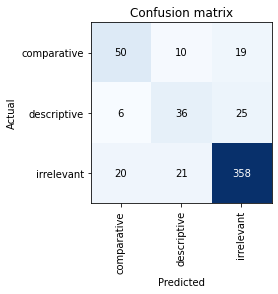

In [86]:
interpretations.plot_confusion_matrix()

In [87]:
y_test = list(target.numpy())
y_pred = preds.numpy()[:,1]

In [88]:
learn.summary()

CustomRobertaModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [181, 768]           38,603,520 True      
______________________________________________________________________
Embedding            [181, 768]           394,752    True      
______________________________________________________________________
Embedding            [181, 768]           768        True      
______________________________________________________________________
LayerNorm            [181, 768]           1,536      True      
______________________________________________________________________
Dropout              [181, 768]           0          False     
______________________________________________________________________
Linear               [181, 768]           590,592    True      
______________________________________________________________________
Linear               [181, 768]           590,592    True      
___________________________________________

In [89]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.29E-06
Min loss divided by 10: 6.31E-06


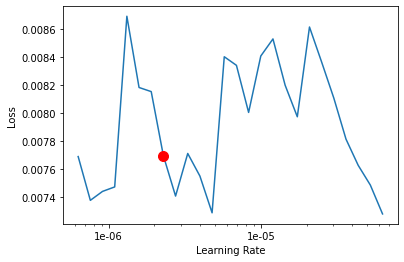

In [90]:
learn.recorder.plot(skip_end=10,suggestion=True)

In [53]:
text = "this rubber is  very bad!"
learn.predict(text)

(Category tensor(1), tensor(1), tensor([5.6368e-04, 9.1581e-01, 8.3624e-02]))

In [54]:
text = "I love this rubber its very sturdy...."
learn.predict(text)

(Category tensor(1), tensor(1), tensor([3.5925e-04, 9.8167e-01, 1.7971e-02]))

In [55]:
# With scale

In [56]:

def biggernum(arr):
    if arr[0] > arr[1]:
        return arr[0]
    else: 
        return arr[1]

In [57]:
def prediction(str): 
    pred = learn.predict(str)
    print('The review class is: ', pred[0], ',',  'with a scale of ','{:.2f} '.format(biggernum(pred[2].numpy()) * 100), 'out of 100.') 

In [58]:
import plotly.express as px

In [59]:
msg1 = "Not sure what quality it is..."
prediction(msg1)
pred = learn.predict(msg1)
vals = [round(biggernum(pred[2].numpy()*100), 2), round(100- biggernum(pred[2].numpy()*100),2)] 
fig = px.pie(pred, values=vals, title=msg1)
fig.show()


The review class is:  irrelevant , with a scale of  0.05  out of 100.


In [60]:
msg2 = "I like hard sponge so t05 is my favourite"
prediction(msg2)
pred = learn.predict(msg2)
vals = [round(biggernum(pred[2].numpy()*100), 2), round(100- biggernum(pred[2].numpy()*100),2)] 
fig = px.pie(pred, values=vals, title=msg2)
fig.show()

The review class is:  comparative , with a scale of  99.59  out of 100.


In [61]:
# Getting Predictions for test data

In [62]:
test_df.head(3)

,id,thread_title,reply_split
0,5f686bc7b59794ca78c70902,Tenergy 05FX vs Tenergy 64FX,"Hi stao, the response of the T64fx changes dep..."
1,5f686bc7b59794ca78c70902,Tenergy 05FX vs Tenergy 64FX,Usually I have a Primorac Carbon and I'm offen...
2,5f686bc7b59794ca78c70902,Tenergy 05FX vs Tenergy 64FX,I used T05fx before and I really appreciate th...


In [63]:
_, test_pred_values = get_preds_as_nparray(DatasetType.Test)
test_pred_values

array([2, 2, 0, 0, ..., 2, 2, 2, 2])

In [64]:
test_df["classification"] = test_pred_values
test_df.head(10)

,id,thread_title,reply_split,classification
0,5f686bc7b59794ca78c70902,Tenergy 05FX vs Tenergy 64FX,"Hi stao, the response of the T64fx changes dep...",2
1,5f686bc7b59794ca78c70902,Tenergy 05FX vs Tenergy 64FX,Usually I have a Primorac Carbon and I'm offen...,2
2,5f686bc7b59794ca78c70902,Tenergy 05FX vs Tenergy 64FX,I used T05fx before and I really appreciate th...,0
3,5f686bc7b59794ca78c70902,Tenergy 05FX vs Tenergy 64FX,On the other hand less spin too.,0
4,5f686bc7b59794ca78c70902,Tenergy 05FX vs Tenergy 64FX,Very good for block.,1
5,5f686bc7b59794ca78c70902,Tenergy 05FX vs Tenergy 64FX,For my style I really prefer T64fx than T05fx ...,0
6,5f686bc7b59794ca78c70902,Tenergy 05FX vs Tenergy 64FX,I bought recently the complete Garaydia family...,2
7,5f686bc7b59794ca78c70902,Tenergy 05FX vs Tenergy 64FX,"With the ALC it is too soft and slow for me, w...",2
8,5f686bc7b59794ca78c70902,Tenergy 05FX vs Tenergy 64FX,I'm truly amazed about the huge difference bet...,2
9,5f686bc7b59794ca78c70902,Tenergy 05FX vs Tenergy 64FX,To finish I'm currently glueing a Dignics 05 o...,2


In [65]:
test_df.tail(10)

,id,thread_title,reply_split,classification
20507,5f6c3825220a4650ffffde10,Differences between Black Globe999Nat and Blac...,Both the Ecolo and glue tend to make the rubbe...,2
20508,5f6c3825220a4650ffffde10,Differences between Black Globe999Nat and Blac...,Yes Alex...I am only just realising the finer ...,2
20509,5f6c3825220a4650ffffde10,Differences between Black Globe999Nat and Blac...,I think globe is faster but not by a mile also...,0
20510,5f6c3825220a4650ffffde10,Differences between Black Globe999Nat and Blac...,I tried Geospin tacky on a friend's racket abo...,2
20511,5f6c3825220a4650ffffde10,Differences between Black Globe999Nat and Blac...,"It's alright for a very slow game, but it feel...",1
20512,5f6c3825220a4650ffffde10,Differences between Black Globe999Nat and Blac...,"999 Nat, on the other hand, has such a dense s...",2
20513,5f6c3825220a4650ffffde10,Differences between Black Globe999Nat and Blac...,My old sheet was lightning fast from the massi...,2
20514,5f6c3825220a4650ffffde10,Differences between Black Globe999Nat and Blac...,It didn't actually die until I tried my homema...,2
20515,5f6c3825220a4650ffffde10,Differences between Black Globe999Nat and Blac...,"I guess I'm not much of a chemist, LOL!",2
20516,5f6c3825220a4650ffffde10,Differences between Black Globe999Nat and Blac...,"Further to Falcoing the Geospin Rubber, the do...",2


In [66]:
test_df.classification.unique()

array([2, 0, 1])

In [67]:
# Saving/Loading the model weights

In [68]:
def save_model(learner, file_name):
    st = learner.model.state_dict()
    torch.save(st, file_name) # will save model in current dir # backend is pickle 

def load_model(learner, file_name):
    st = torch.load(file_name)
    learner.model.load_state_dict(st)

# monkey patching Learner methods to save and load model file
Learner.save_model = save_model
Learner.load_model = load_model

save_model

<function __main__.save_model>

In [69]:
path = 'drive/My Drive/DS4A_PROJECT/eval_1'

In [70]:
learn.save_model('mymodel.path')

In [71]:
learn.load_model('mymodel.path')

In [72]:
results = test_df.replace({'classification': {0:'comparative',1:'descriptive',2:'irrelevant'}})
results.classification.unique()

array(['irrelevant', 'comparative', 'descriptive'], dtype=object)

In [91]:
results.head()

,id,thread_title,reply_split,classification
0,5f686bc7b59794ca78c70902,Tenergy 05FX vs Tenergy 64FX,"Hi stao, the response of the T64fx changes dep...",irrelevant
1,5f686bc7b59794ca78c70902,Tenergy 05FX vs Tenergy 64FX,Usually I have a Primorac Carbon and I'm offen...,irrelevant
2,5f686bc7b59794ca78c70902,Tenergy 05FX vs Tenergy 64FX,I used T05fx before and I really appreciate th...,comparative
3,5f686bc7b59794ca78c70902,Tenergy 05FX vs Tenergy 64FX,On the other hand less spin too.,comparative
4,5f686bc7b59794ca78c70902,Tenergy 05FX vs Tenergy 64FX,Very good for block.,descriptive


In [92]:
results.classification.unique()

array(['irrelevant', 'comparative', 'descriptive'], dtype=object)

In [93]:
results.to_csv("final_eval_1.csv")